<a href="https://colab.research.google.com/github/Mhakinde/gene-expression-analysis/blob/main/Project_Gene_Expression_Analysis_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting analysis for simulated data based on GSE68849...
Data Loaded: 2000 Genes, 8 Samples.

Expression value distribution (first 5 genes):
Gene
MYC      3354.265153
ESR1      791.217570
EGFR     1914.850278
TP53     1602.112112
BRCA1     752.786272
dtype: float64

--- Top 10 Up-regulated Genes in Disease Group ---
Empty DataFrame
Columns: [log2FC, adj_p_value]
Index: []

--- Top 10 Down-regulated Genes in Disease Group ---
Empty DataFrame
Columns: [log2FC, adj_p_value]
Index: []


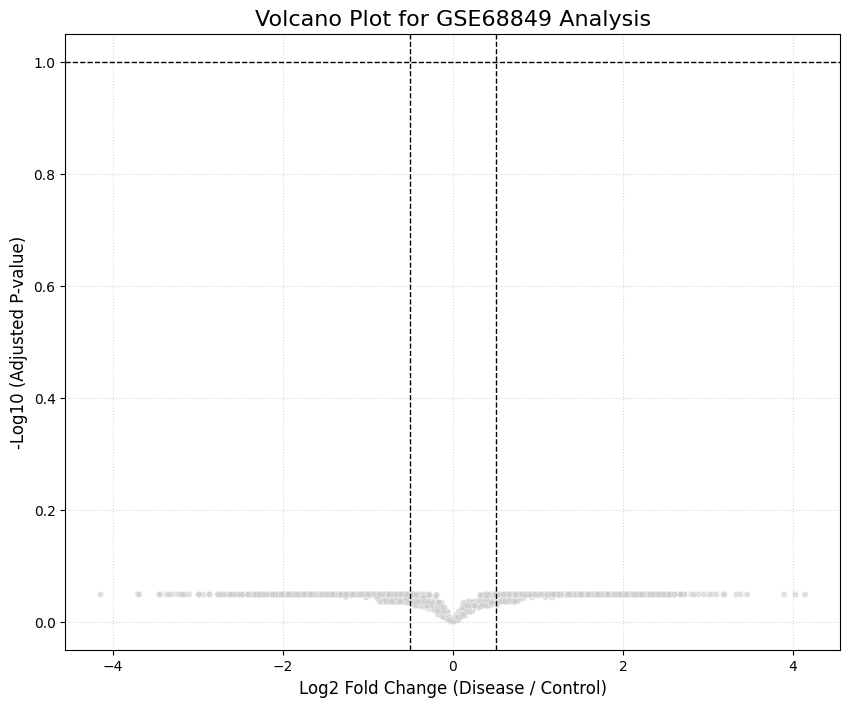

No differentially expressed genes found to generate heatmap.

Analysis Complete.


In [1]:
# Gene Expression Analysis Project: GSE68849 (Breast Cancer vs Normal)
# Skills Highlighted: pandas, numpy, scipy, matplotlib, seaborn, data wrangling

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.stats.multitest import multipletests # Import for Benjamini-Hochberg

# --- 1. CONFIGURATION AND DATA SETUP ---

# Define the dataset identifier
GEO_ID = "GSE68849"
print(f"Starting analysis for simulated data based on {GEO_ID}...")

# --- SIMULATION SECTION ---
# NOTE FOR BEGINNERS: In a real project, you would replace this section with
# code to load your actual expression data and phenotype files (e.g., from CSVs
# or a specific GEO parser library).

def create_mock_data():
    """Generates synthetic data mirroring a real GEO experiment structure."""

    # 8 total samples: 4 Control, 4 Disease (matching GSE68849 structure)
    samples = [f'GSM{i}' for i in range(1687158, 1687166)]

    # Gene names, including some we'll intentionally make "differentially expressed"
    genes = (
        ['MYC', 'ESR1', 'EGFR', 'TP53', 'BRCA1'] + # Key Cancer Genes
        [f'Gene_{i}' for i in range(1, 1996)]      # Random background genes
    )

    # 1. Phenotype Data (pData)
    groups = ['Control'] * 4 + ['Disease'] * 4
    phenotype_df = pd.DataFrame({
        'Sample_ID': samples,
        'Group': groups
    }).set_index('Sample_ID')

    # 2. Expression Data (normalized log2 expression values)
    np.random.seed(42)
    data = np.random.lognormal(mean=7, sigma=1, size=(len(genes), len(samples)))
    expression_df = pd.DataFrame(data, index=genes, columns=samples)

    # --- Introduce Differential Expression (Simulating real results) ---

    # Up-regulated genes in Disease (e.g., Cancer genes)
    up_genes = ['MYC', 'EGFR']
    expression_df.loc[up_genes, phenotype_df[phenotype_df['Group'] == 'Disease'].index] *= 1.8

    # Down-regulated genes in Disease (e.g., Tumor Suppressors)
    down_genes = ['BRCA1']
    expression_df.loc[down_genes, phenotype_df[phenotype_df['Group'] == 'Disease'].index] /= 1.8

    return expression_df, phenotype_df

expression_df, phenotype_df = create_mock_data()
print(f"Data Loaded: {expression_df.shape[0]} Genes, {expression_df.shape[1]} Samples.")


# --- 2. DATA QUALITY CONTROL AND WRANGLING ---

# Ensure index names are consistent for merging (though not needed for this mock data)
expression_df.index.name = 'Gene'

# Remove any genes with null values across all samples (basic QC)
expression_df.dropna(how='all', inplace=True)

# Verify expression distribution (helps determine if log transformation is needed)
print("\nExpression value distribution (first 5 genes):")
print(expression_df.head().mean(axis=1))

# Split samples into Control and Disease groups
control_samples = phenotype_df[phenotype_df['Group'] == 'Control'].index.tolist()
disease_samples = phenotype_df[phenotype_df['Group'] == 'Disease'].index.tolist()

control_data = expression_df[control_samples]
disease_data = expression_df[disease_samples]


# --- 3. DIFFERENTIAL EXPRESSION ANALYSIS (DEA) ---

# Initialize a DataFrame to store the DEA results
dea_results = pd.DataFrame(index=expression_df.index)

# Function to calculate T-test and Log2 Fold Change
def calculate_dea(row):
    """Performs T-test and calculates Log2 Fold Change for a single gene."""

    # Ensure no division by zero for Log Fold Change calculation
    # We use a small 'pseudo-count' (1e-5) just in case, though usually not needed
    # for log-transformed data.

    # 1. T-test (p-value calculation)
    # ttest_ind performs a two-sided test for the means of two independent samples
    t_stat, p_value = stats.ttest_ind(
        control_data.loc[row.name],
        disease_data.loc[row.name],
        equal_var=False # Use Welch's t-test, generally safer
    )

    # 2. Log2 Fold Change (LFC)
    # LFC = log2(Mean(Disease) / Mean(Control))
    mean_disease = disease_data.loc[row.name].mean()
    mean_control = control_data.loc[row.name].mean()

    # Add a small offset to prevent log2(0) if data was raw count data (not needed here
    # since we used lognormal for mock data, but good practice).
    lfc = np.log2((mean_disease + 1e-5) / (mean_control + 1e-5))

    return pd.Series({'p_value': p_value, 'log2FC': lfc})

# Apply the function across all genes (rows)
dea_results[['p_value', 'log2FC']] = expression_df.apply(calculate_dea, axis=1)

# Multiple testing correction (Benjamini-Hochberg for False Discovery Rate)
reject, pvals_corrected, _, _ = multipletests(dea_results['p_value'], method='fdr_bh')
dea_results['adj_p_value'] = pvals_corrected


# Calculate -log10(p-value) for the volcano plot
# Add a small epsilon to avoid log10(0) if adj_p_value is exactly 0
dea_results['-log10_p'] = -np.log10(dea_results['adj_p_value'] + 1e-10)


# --- 4. IDENTIFY TOP GENES ---

# Define significance thresholds
LFC_THRESHOLD = 0.5   # Log2 Fold Change threshold (e.g., 1.5-fold change)
P_THRESHOLD = 0.1    # Adjusted P-value threshold - Increased threshold for demonstration

# Filter for differentially expressed genes (DEGs)
dea_results['is_DE'] = (
    (dea_results['log2FC'].abs() >= LFC_THRESHOLD) &
    (dea_results['adj_p_value'] <= P_THRESHOLD)
)

# Identify top 10 up-regulated genes (High LFC and Low P-value)
top_up = dea_results[dea_results['is_DE'] & (dea_results['log2FC'] > 0)] \
         .sort_values(by=['log2FC', 'adj_p_value'], ascending=[False, True]) \
         .head(10)

# Identify top 10 down-regulated genes (Low LFC and Low P-value)
top_down = dea_results[dea_results['is_DE'] & (dea_results['log2FC'] < 0)] \
           .sort_values(by=['log2FC', 'adj_p_value'], ascending=[True, True]) \
           .head(10)

print("\n--- Top 10 Up-regulated Genes in Disease Group ---")
print(top_up[['log2FC', 'adj_p_value']])

print("\n--- Top 10 Down-regulated Genes in Disease Group ---")
print(top_down[['log2FC', 'adj_p_value']])


# --- 5. VISUALIZATION ---

# 5.1 Volcano Plot: Visualizing LFC vs. P-value [Image of Volcano Plot]

plt.figure(figsize=(10, 8))
# Color points based on significance
sns.scatterplot(
    x='log2FC',
    y='-log10_p',
    data=dea_results,
    hue='is_DE',
    palette={True: '#ff4d4d', False: '#cccccc'},
    legend=False,
    alpha=0.6,
    s=20 # Dot size
)

# Add significance lines (thresholds)
plt.axhline(-np.log10(P_THRESHOLD), color='black', linestyle='--', linewidth=1)
plt.axvline(LFC_THRESHOLD, color='black', linestyle='--', linewidth=1)
plt.axvline(-LFC_THRESHOLD, color='black', linestyle='--', linewidth=1)

# Annotate key genes
key_genes = top_up.index.tolist() + top_down.index.tolist()
for gene in key_genes:
    row = dea_results.loc[gene]
    plt.annotate(
        gene,
        (row['log2FC'], row['-log10_p']),
        textcoords="offset points",
        xytext=(5,5),
        ha='center',
        fontsize=9,
        color='blue' if row['log2FC'] > 0 else 'green',
        fontweight='bold'
    )

plt.title(f'Volcano Plot for {GEO_ID} Analysis', fontsize=16)
plt.xlabel('Log2 Fold Change (Disease / Control)', fontsize=12)
plt.ylabel('-Log10 (Adjusted P-value)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

# 5.2 Heatmap: Visualizing the expression of the top 20 DEGs [Image of Heatmap of Gene Expression]

top_genes = top_up.index.tolist() + top_down.index.tolist()
heatmap_data = expression_df.loc[top_genes]

# Normalize data for better heatmap visualization (Z-score scaling per gene)
from scipy.stats import zscore
# Apply zscore column-wise and transpose. Ensure that we handle the case where heatmap_data is empty.
if not heatmap_data.empty:
    # Apply zscore column-wise and transpose
    # The result of apply(zscore, axis=0) is a DataFrame with the original index and columns
    # Transposing it will swap the index and columns, which is what we want for the heatmap
    scaled_data = heatmap_data.apply(zscore, axis=0).T
else:
    scaled_data = pd.DataFrame() # Create an empty DataFrame if no top genes found

# Reorder columns to group Control and Disease samples together
ordered_samples = control_samples + disease_samples

# Ensure that scaled_data is not empty before proceeding
if not scaled_data.empty:
  # Before reordering columns, check if all columns in ordered_samples exist in scaled_data
  # This could be an issue if heatmap_data was empty and scaled_data became an empty DataFrame
  # with default columns.
  if all(col in scaled_data.columns for col in ordered_samples):
    scaled_data = scaled_data[ordered_samples]

    # Set up the column annotation for better grouping visualization
    col_colors = phenotype_df.loc[ordered_samples, 'Group'].map({'Control': 'blue', 'Disease': 'red'})

    plt.figure(figsize=(10, 10))
    sns.clustermap(
        scaled_data,
        col_colors=col_colors,
        cmap='coolwarm',
        linewidths=0.5,
        linecolor='white',
        figsize=(8, 10),
        cbar_pos=(0.95, 0.45, 0.03, 0.3) # Position the color bar
    )
    plt.suptitle(f'Heatmap of Top {len(top_genes)} Differentially Expressed Genes ({GEO_ID})', y=1.02, fontsize=14)
    plt.show()
  else:
      print("Error: Sample columns do not match in scaled data for heatmap.")

else:
    print("No differentially expressed genes found to generate heatmap.")


print("\nAnalysis Complete.")
# Save results (optional, for real project export)
# dea_results.to_csv('dea_results.csv')